# Test d'entrainement d'un model pour classifier des image d'anime de 2023 

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib 
import os
import tensorflow as tf
import keras_tuner as kt 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Chargement des images

In [30]:
data_dir = pathlib.Path('data/anime_images')
print(data_dir)
print(os.path.abspath(data_dir))

data/anime_images
/home/ssea2/Desktop/IA/vision_recoperso/Projet-IA/data/anime_images


In [31]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

83060


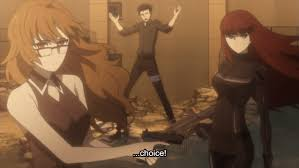

In [32]:
anime_images = list(data_dir.glob('*/*'))
PIL.Image.open(str(anime_images[9]))

# Load data using a Keras utility

In [33]:
batch_size = 32
img_height = 128
img_width = 128

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  labels="inferred",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83066 files belonging to 232 classes.
Using 66453 files for training.


In [36]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83066 files belonging to 232 classes.
Using 16613 files for validation.


In [8]:
class_names = train_ds.class_names
print(len(class_names),class_names)

232 ['A Lull in the Sea', 'A Place Further Than The Universe', 'A Silent Voice', 'AKIRA', 'Ace of Diamond', 'Akatsuki no Yona', 'Angel Beats!', 'Aria The Natural', 'Aria The Origination', 'Assassination Classroom', 'Attack on Titan', 'Baccano!', 'Bakemonogatari', 'Bakuman', 'Barakamon', 'Beck Mongolian Chop Squad', 'Berserk', 'Big Windup!', 'Black Butler', 'Black Lagoon', 'Bunny Drop', 'Cardcaptor Sakura', 'Carpcaptor Sakura', 'Castle in the Sky', 'Chihayafuru', 'Clannad', 'Code Geass', 'Cross Game', 'D.Gray-man', 'DARLING in the FRANXX', 'Daily Lives of High School Boys', 'Darker than Black', 'Death Note', 'Death Parade', 'Den-noh Coil', 'Descending Stories Showa Genroku Rakugo Shinju', 'Detective Conan', 'Detroit Metal City The Animated Series', 'Dragon Ball', 'Dragon Ball Z', 'Durarara', 'Durarara!!', 'ERASED', 'Erin', 'Eureka Seven', 'FateZero', 'Fatestay night', 'Fighting Spirit Special', 'From the New World', 'Full Metal Panic', 'Fullmetal Alchemist Brotherhood', 'Gankutsuou The 

# Visualize the data

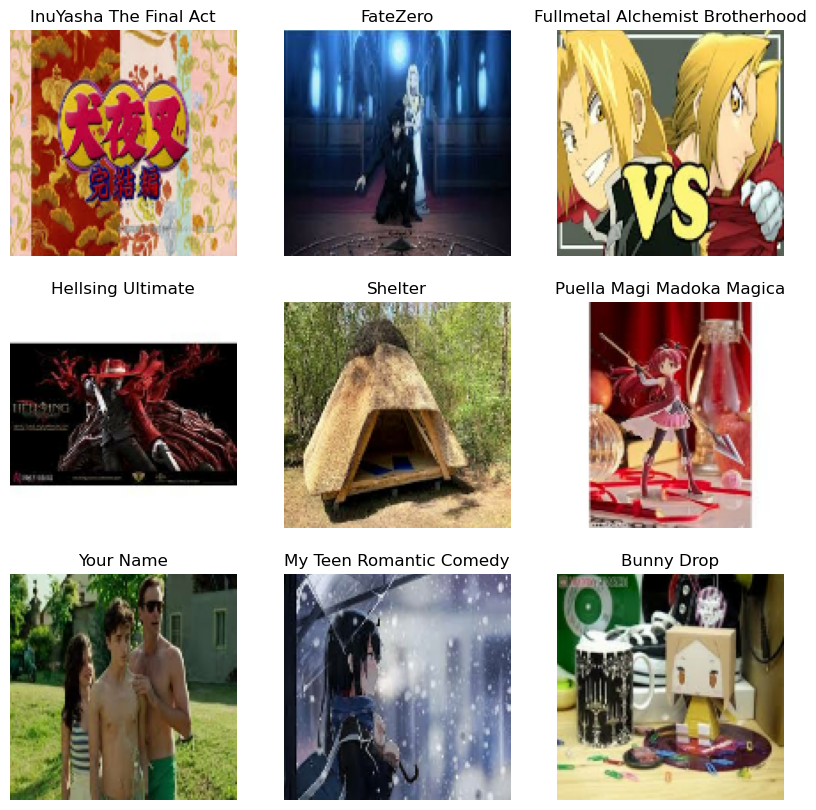

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


# Configure the dataset for performance

In [11]:
"""AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)"""

'AUTOTUNE = tf.data.AUTOTUNE\n\ntrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)'

# Standardize the data

In [39]:
normalization_layer = layers.Rescaling(1./255)

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9653072


# Create the model

In [41]:
num_classes = len(class_names)

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(128, 128)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(num_classes))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [42]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [46]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

NameError: name 'label_train' is not defined